# Doppler Shift

We take $v_{out} = 25$ km/s with $v_{rot} = 0$ km/s. Then we Doppler shift it to reproduce $v_{out} = 25$ km/s with $v_{rot} = 50$ km/s

This is an example:

![example](../../paper/figures/rotation_doppler_outflow.png)

Ly$\alpha$ scattering through an optically thick gas cloud that is undergoing solid-body rotation (i.e. in which the angular speed around the rotation axis is identical for each hydrogen atom) proceeds identical as in a static cloud. In order to compute the spectrum emerging from a rotating cloud, we sum the spectra emerging from all surface elements of the cloud, weighted by their intensity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D

plt.rc('text', usetex=True)
plt.rc('font', size=20)

In [2]:
# Values

tau = 100000
vrot = 0
vrot_new = 50
vout = 25

In [3]:
# Reading data

fname = '../../data/tau10E5/vrot'+str(vrot)+'/vout'+str(vout)+'/tau10E5_vrot'+str(vrot)+'_vout'+str(vout)+'_out.ascii'
df = pd.read_csv(fname, delimiter=' ', dtype='float64')
        
escaped = df['escaped']
x = df['x']
y = df['y']
z = df['z']
x_u = df['x_u']
y_u = df['y_u']
z_u = df['z_u']
x_frec = df['x_frec']

inds = np.where(escaped == 0)[0]

x_escaped = np.array(x)[inds]
y_escaped = np.array(y)[inds]
z_escaped = np.array(z)[inds]
x_u_escaped = np.array(x_u)[inds]
y_u_escaped = np.array(y_u)[inds]
z_u_escaped = np.array(z_u)[inds]
x_frec_escaped = np.array(x_frec)[inds]

num_photons_escaped = len(x_escaped)

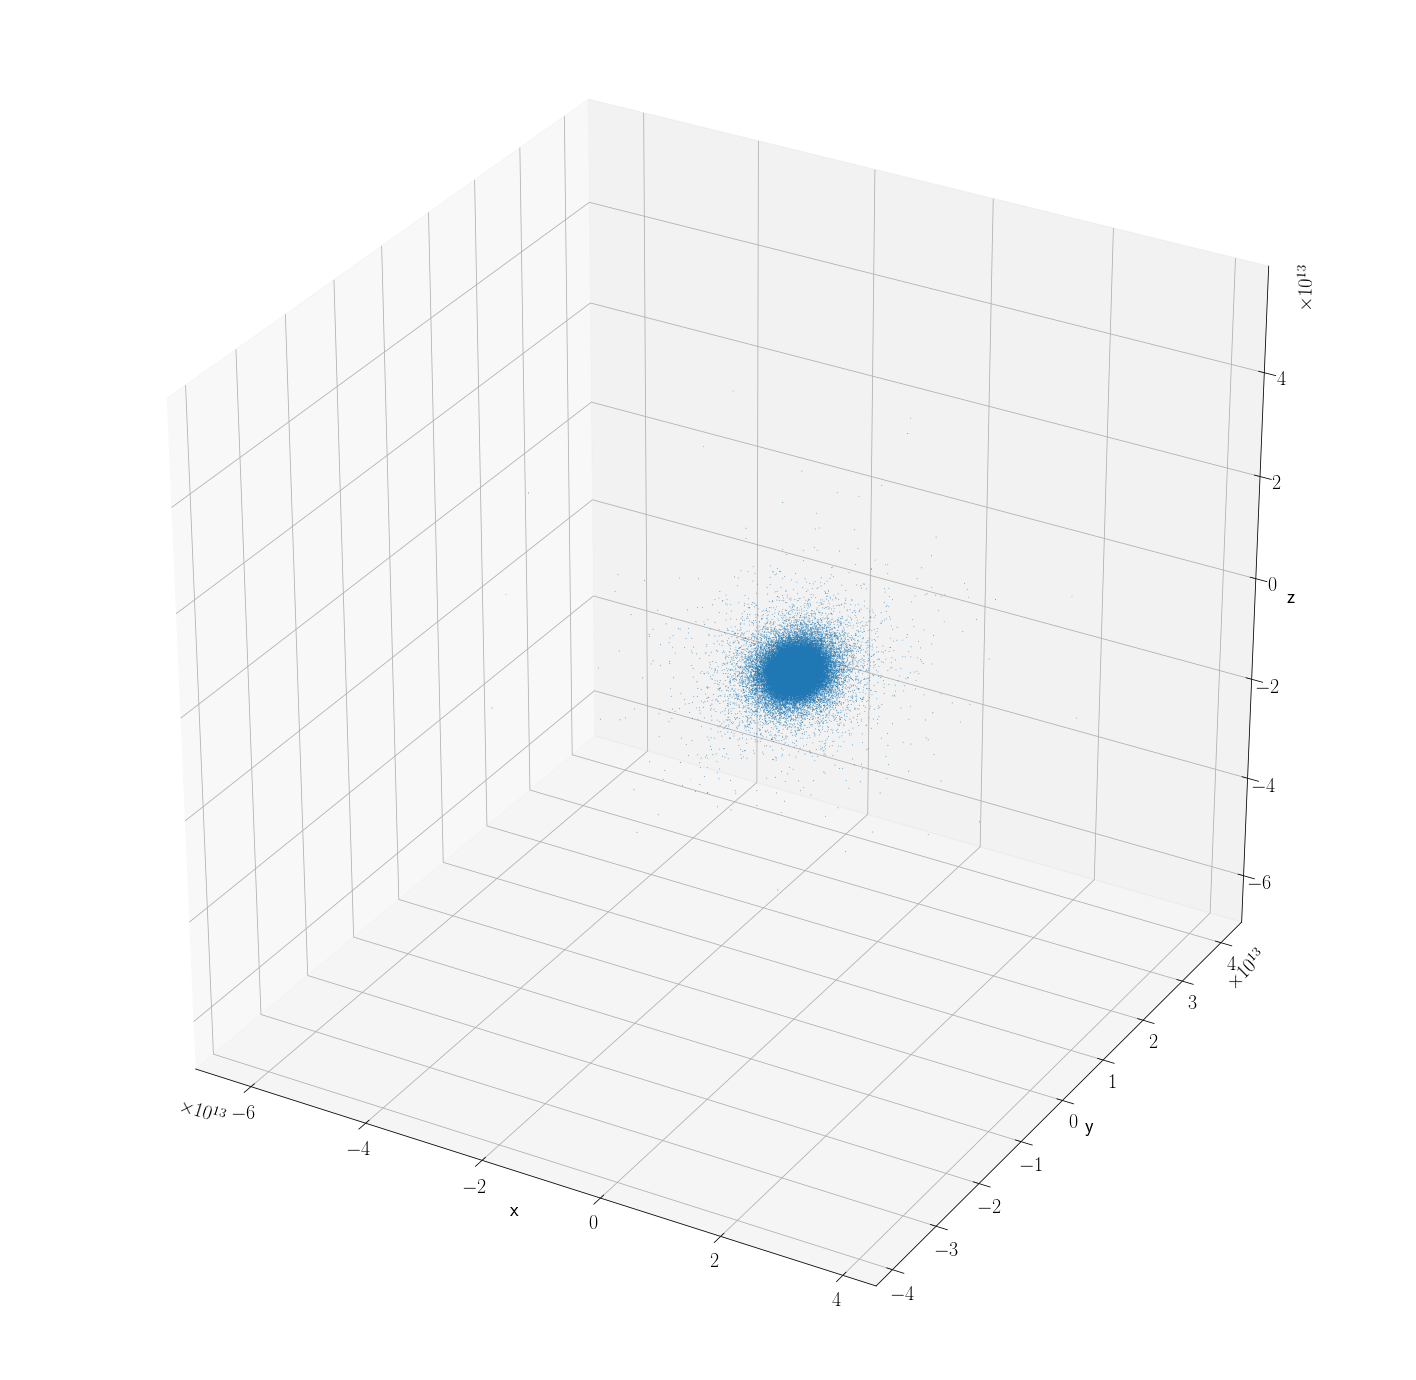

In [4]:
# Plot of final position of photons

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_escaped, y_escaped, z_escaped, s=1, lw = 0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [5]:
# Defining angle ranges

num_thetas = 9
cos_thetas = np.linspace(0,1,num_thetas+1) 
cos_thetas_plus = np.linspace(-1,0,num_thetas+1) 

thetas = np.sort(np.array([np.arccos(ct) for ct in cos_thetas]))
thetas_plus = np.array([np.arccos(ctp) for ctp in cos_thetas_plus])

num_phis = 180
phis = np.linspace(0,2*np.pi,num_phis+1) 

In [6]:
# TEMPORARY (meanwhile I calculate what the radius is)

distance = np.sqrt(x_escaped**2 + y_escaped**2 + z_escaped**2)
R = np.min(distance) # Calculate real R

In [7]:
# Get the real positions in the sphere at which the photons escaped

r_escaped_squared = x_escaped**2 + y_escaped**2 + z_escaped**2
k_u_escaped_squared = x_u_escaped**2 + y_u_escaped**2 + z_u_escaped**2
r_escaped_dot_k_u_escaped = x_escaped*x_u_escaped + y_escaped*y_u_escaped + z_escaped*z_u_escaped

t_a = k_u_escaped_squared
t_b = 2.0*r_escaped_dot_k_u_escaped
t_c = r_escaped_squared - R**2

t_plus = (-t_b + np.sqrt(t_b**2 - 4*t_a*t_c))/(2*t_a)
t_minus = (-t_b - np.sqrt(t_b**2 - 4*t_a*t_c))/(2*t_a)
t = []

for i in range(num_photons_escaped):
    t_p = t_plus[i]
    t_m = t_minus[i]
    t.append(np.amax([t_p, t_m]))

t = np.array(t)

x_escaped_sphere = x_escaped + x_u_escaped*t
y_escaped_sphere = y_escaped + y_u_escaped*t
z_escaped_sphere = z_escaped + z_u_escaped*t

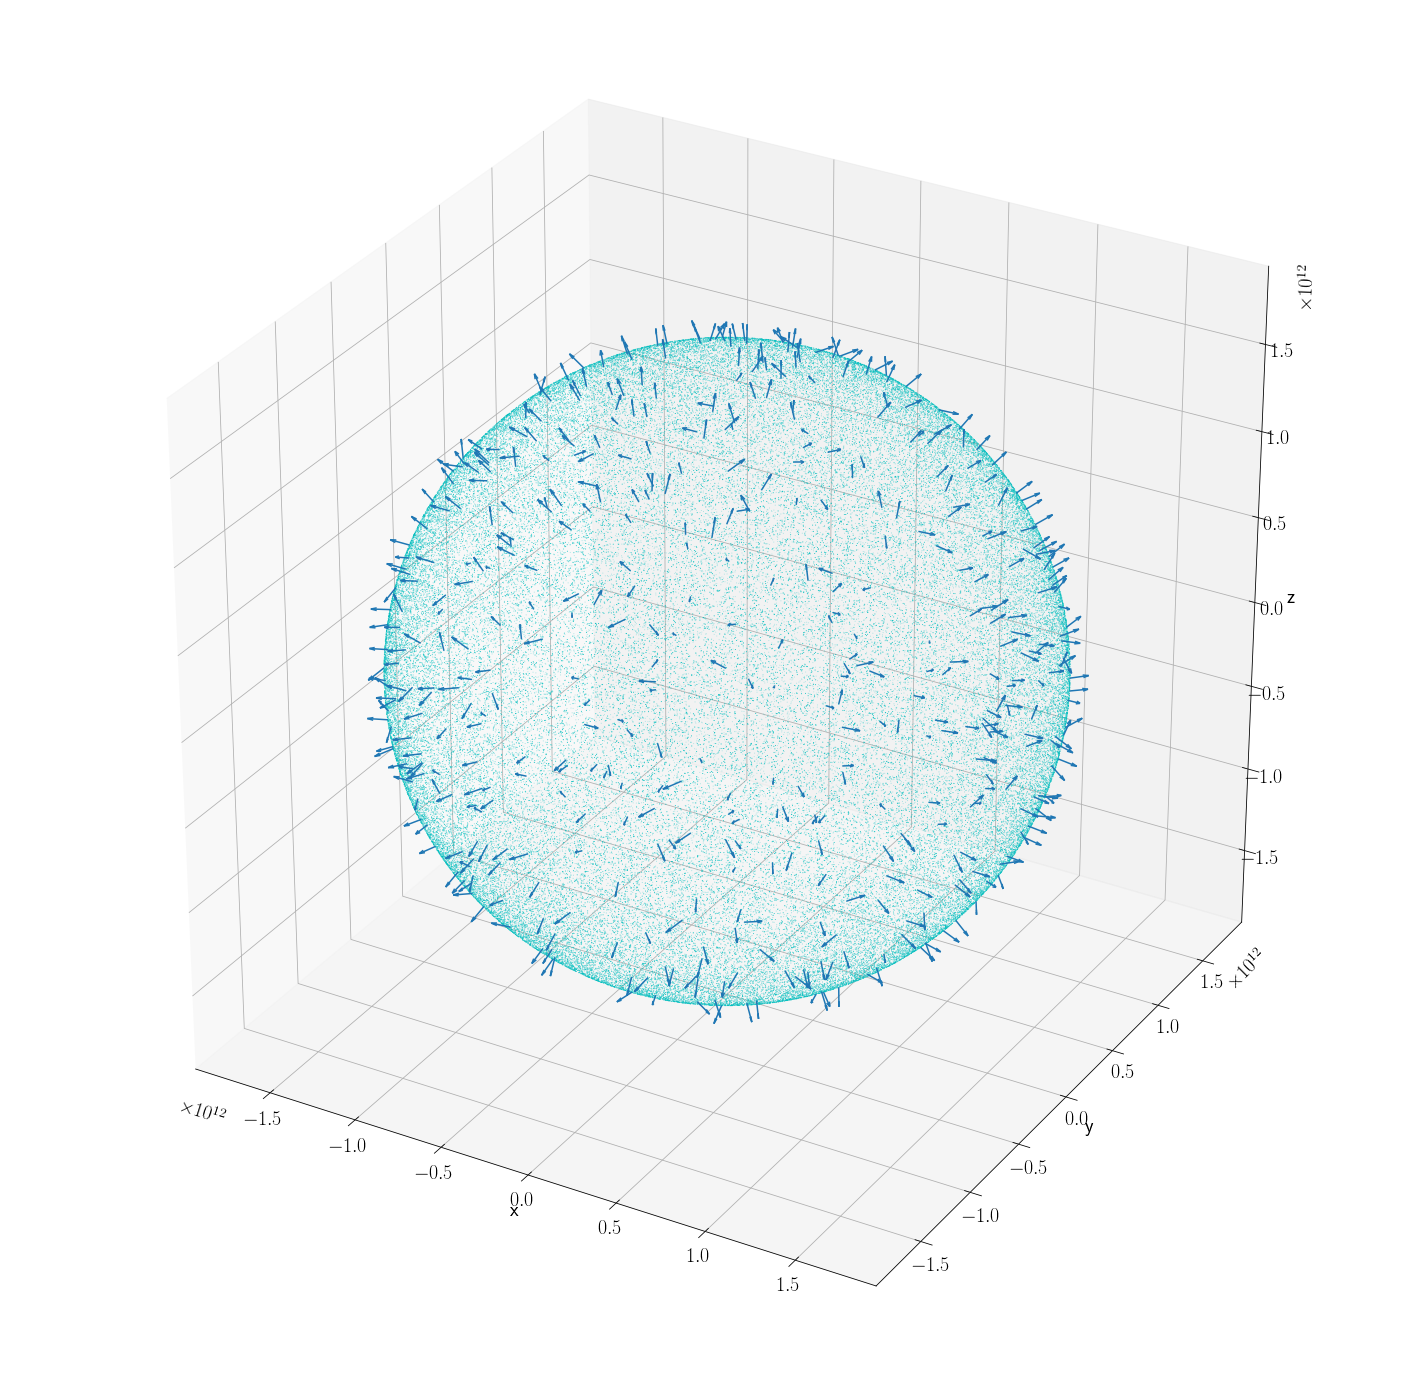

In [8]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_escaped_sphere, y_escaped_sphere, z_escaped_sphere, s=1, lw = 0, c='c')
ax.quiver(x_escaped_sphere[0:500], y_escaped_sphere[0:500], z_escaped_sphere[0:500], x_u_escaped[0:500], y_u_escaped[0:500], z_u_escaped[0:500], length=1E11)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [9]:
# Unitary vectors in the x, y, z directions

x_unitary = x_escaped_sphere/R
y_unitary = y_escaped_sphere/R
z_unitary = z_escaped_sphere/R

In [10]:
# Atom velocities

v_x = - y_unitary*vrot_new
v_y = x_unitary*vrot_new
v_z = np.zeros(len(z_unitary))

In [11]:
# Getting final wavelength

v_th = -12.8
final_velocities = []

theta_lower = thetas[-2]
theta_upper = thetas[-1]
theta_plus_lower = thetas_plus[-1]
theta_plus_upper = thetas_plus[-2]

acos_x_escaped_pos = np.array([np.arccos(xu) for xu in x_unitary])
acos_x_escaped_neg = np.array([2.0*np.pi-np.arccos(xu) for xu in x_unitary])

for n_phi in range(num_phis):
    phi_lower = phis[n_phi]
    phi_upper = phis[n_phi+1]
    phi_middle = (phi_lower + phi_upper)/2.0
    
    r_observer = np.array([np.cos(phi_middle), np.sin(phi_middle), 0])
        
    phi_indices_pos = np.where( ((y_escaped >= 0) & (acos_x_escaped_pos >= phi_lower) & (acos_x_escaped_pos < phi_upper)) )[0]
    phi_indices_neg = np.where( ((y_escaped < 0) & (acos_x_escaped_neg >= phi_lower) & (acos_x_escaped_neg < phi_upper)) )[0]
    phi_indices = np.concatenate((phi_indices_pos, phi_indices_neg))
    
    x_frec_escaped_phis = x_frec_escaped[phi_indices]
    z_u_escaped_phis = z_u_escaped[phi_indices]
    acos_z_u_escaped_phis = np.array([np.arccos(zu) for zu in z_u_escaped_phis])
    
    theta_indices = np.where( ((acos_z_u_escaped_phis >= theta_lower) & (acos_z_u_escaped_phis < theta_upper)) )[0]
    
    x_frec_escaped_thetas = x_frec_escaped_phis[theta_indices]    
    
    v_x_phis = v_x[phi_indices]
    v_y_phis = v_y[phi_indices]
    v_z_phis = v_z[phi_indices]
    
    shift_factors_phis = v_x_phis*r_observer[0] + v_y_phis*r_observer[1] + v_z_phis*r_observer[2]
    
    shift_factors_thetas = shift_factors_phis[theta_indices]
    
    shifted_velocities = x_frec_escaped_thetas*v_th + shift_factors_thetas

    final_velocities = np.concatenate((final_velocities, shifted_velocities))

In [12]:
# Plot

fig = plt.figure(1, (10., 6.))

props = dict(boxstyle='square', facecolor='white')    

vrot_lab = r'${0:.0f}$'.format(vrot_new)
vout_lab = r'${0:.0f}$'.format(vout)
theta_lower_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_lower)))
theta_upper_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_upper)))

theta_lab = r'$\theta=$ '
lab = '$v_{rot}=$ '+vrot_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$\n $v_{out}=$ '+vout_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$'

n, b = np.histogram(final_velocities, bins=40)        
delta_v = b[1]-b[0]
area = delta_v * sum(n)
n = n/area

border_x = []
border_y = []

for j in range(len(n)-1):
    border_x.append(b[j]+delta_v/2)
    border_x.append(b[j]+delta_v/2)
    border_y.append(n[j])
    border_y.append(n[j+1])

plt.bar(b[0:40], n, width=delta_v, color='c', edgecolor=None, alpha = 1)
plt.plot(border_x, border_y, c='k', linewidth=1)

plt.axvline(x=0, ymin=0, ymax=1, c='k', linestyle='--', linewidth=1)
plt.xlim(-200,250)
plt.ylim(0,0.013)
plt.ylabel('$\mathrm{Intensity}$')
plt.xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')
plt.text(-180,0.011, lab, fontsize=20, bbox=props)

plt.savefig('doppler_shift_shifted.png', format='png', transparent=False, bbox_inches='tight')
plt.close()

In [18]:
#Reading data

fname = '../../data/tau10E5/vrot'+str(vrot_new)+'/vout'+str(vout)+'/tau10E5_vrot'+str(vrot_new)+'_vout'+str(vout)+'_out.ascii'
df = pd.read_csv(fname, delimiter=' ', dtype='float64')
        
escaped = df['escaped']
x = df['x']
y = df['y']
z = df['z']
x_u = df['x_u']
y_u = df['y_u']
z_u = df['z_u']
x_frec = df['x_frec']

inds = np.where(escaped == 0)[0]

x_escaped = np.array(x)[inds]
y_escaped = np.array(y)[inds]
z_escaped = np.array(z)[inds]
x_u_escaped = np.array(x_u)[inds]
y_u_escaped = np.array(y_u)[inds]
z_u_escaped = np.array(z_u)[inds]
x_frec_escaped = np.array(x_frec)[inds]

In [19]:
v_th = -12.8

theta_lower = thetas[-2]
theta_upper = thetas[-1]
theta_plus_lower = thetas_plus[-1]
theta_plus_upper = thetas_plus[-2]


fig = plt.figure(1, (10., 6.))

props = dict(boxstyle='square', facecolor='white')

acos_z_u_escaped = np.array([np.arccos(zu) for zu in z_u_escaped])
angle_indices = np.where( ((acos_z_u_escaped >= theta_lower) & (acos_z_u_escaped < theta_upper)) | ((acos_z_u_escaped >= theta_plus_lower) & (acos_z_u_escaped < theta_plus_upper)))[0]

current_x = x_frec_escaped[angle_indices] #only the ones between those upper and lower angles
current_x_vel = current_x*v_th 

vrot_lab = r'${0:.0f}$'.format(vrot_new)
vout_lab = r'${0:.0f}$'.format(vout)
theta_lower_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_lower)))
theta_upper_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_upper)))

theta_lab = r'$\theta=$ '
lab = '$v_{rot}=$ '+vrot_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$\n $v_{out}=$ '+vout_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$'

n, b = np.histogram(current_x_vel, bins=40)        
delta_x = b[1]-b[0]
area = delta_x * sum(n)
n = n/area

border_x = []
border_y = []

for j in range(len(n)-1):
    border_x.append(b[j]+delta_x/2)
    border_x.append(b[j]+delta_x/2)
    border_y.append(n[j])
    border_y.append(n[j+1])

plt.bar(b[0:40], n, width=delta_x, color='c', edgecolor=None, alpha = 1)
plt.plot(border_x, border_y, c='k', linewidth=1)

plt.axvline(x=0, ymin=0, ymax=1, c='k', linestyle='--', linewidth=1)
plt.xlim(-200,250)
plt.ylim(0,0.013)
plt.ylabel('$\mathrm{Intensity}$')
plt.xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')
plt.text(-180,0.011, lab, fontsize=20, bbox=props)

plt.savefig('doppler_shift_original.png', format='png', transparent=False, bbox_inches='tight')
plt.close()